# Detection 모델들의 결합 : Faster R-CNN(15), SSD(16), YOLO v3(18)

In [ ]:
!pip install torchsummary

In [ ]:
!pip install --upgrade torchvision

In [ ]:
!pip install --upgrade torch

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.models.detection.anchor_utils as anchor_utils
import numpy as np
import torch.nn.functional as F
from torchvision.ops import nms

# CUDA GPU가 사용 가능한 경우, GPU를 사용하고 그렇지 않은 경우 CPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 모델 구성 1번째 : 백본 네트워크 VGG-16(Faster R-CNN) + Darknet-53(YOLO v3)

- backbone network : object detection에서 이미지의 특징을 추출하는 역할
    > - 주로 사전 훈련된 CNN 아키텍처를 사용하며, 이미지의 다양한 정보를 특징 맵으로 변환
    > - 이 특징 맵은 후속 네트워크(예: RPN, 분류 네트워크)에서 객체 탐지를 위해 사용
    > - 특징 추출 과정에서 이미지의 고수준 특징을 추출하여 객체의 모양, 경계, 색상 등 다양한 정보를 포함

- backbone network 통합 방법
    > 1. Input Layer - Convolutional Layer (16 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 2. Convolutional Layer (32 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 3. Max Pooling Layer (2x2 풀링, 스트라이드 2)
    > 4. Convolutional Layer (64 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 5. Convolutional Layer (64 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 6. Max Pooling Layer (2x2 풀링, 스트라이드 2)
    > 7. Convolutional Layer (128 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 8. Convolutional Layer (64 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 9. Convolutional Layer (128 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 10. Max Pooling Layer (2x2 풀링, 스트라이드 2)
    > 11. Convolutional Layer (256 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 12. Convolutional Layer (128 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 13. Convolutional Layer (256 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 14. Convolutional Layer (128 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 15. Convolutional Layer (256 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 16. Max Pooling Layer (2x2 풀링, 스트라이드 2)
    > 17. Convolutional Layer (512 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 18. Convolutional Layer (256 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 19. Convolutional Layer (512 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 20. Convolutional Layer (256 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 21. Convolutional Layer (512 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 22. Max Pooling Layer (2x2 풀링, 스트라이드 2)
    > 23. Convolutional Layer (1024 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 24. Convolutional Layer (512 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 25. Convolutional Layer (1024 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 26. Convolutional Layer (512 필터, 1x1 커널, 스트라이드 1, 패딩 0)
    > 27. Convolutional Layer (1024 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 28. Convolutional Layer (1024 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 29. Convolutional Layer (1024 필터, 3x3 커널, 스트라이드 1, 패딩 1)
    > 30. Global Average Pooling

## 모델 구성 2번째 : 멀티 스케일 특징 맵(SSD)

- SSD에서 멀티 스케일 특징 맵 : 객체 감지를 다양한 크기와 종횡비의 객체에 대해 효과적으로 수행하기 위한 중요한 구성 요소
    > - 여러 가지 크기의 객체를 탐지하기 위해 입력 이미지를 다양한 해상도로 다운샘플링하여 생성
    > - 주요 역할 1 : 다양한 객체 크기 대응
    > - 주요 역할 2 : 객체 위치 정밀도 향상
    > - 주요 역할 3 : 효율적인 감지 $\Rightarrow$ 다양한 스케일의 특징 맵을 병렬로 처리하여 객체 감지 빠르게 수행

torch.Size([1, 3, 4160, 3120])


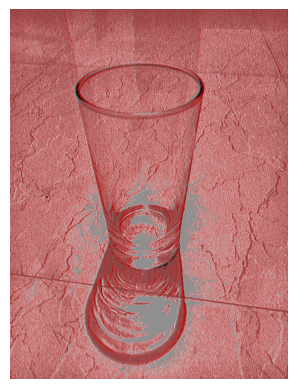

In [3]:
# 예시 input tensor 적용

from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# 이미지를 로드합니다.
image_path = "./transparent data(Real)/preprocessingReal/image/t35.jpg"  # 실제 이미지 경로로 바꾸어 주세요.
image = Image.open(image_path)

# 이미지를 텐서로 변환합니다.
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL 이미지를 PyTorch 텐서로 변환합니다.
])

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # 배치 차원을 추가합니다.
input_tensor = image_tensor
print(input_tensor.size())

# 이미지로 다시 변환
# input_tensor의 배치 차원을 제거합니다.
image_tensor = image_tensor.squeeze(0)
# PyTorch 텐서를 numpy 배열로 변환합니다.
image_numpy = image_tensor.numpy().transpose((1, 2, 0))
# 이미지를 출력합니다.
plt.imshow(image_numpy)
plt.axis('off')  # 축 정보를 끕니다.
plt.show()

In [4]:
class CustomBackbone_MultiScaleFeatureMap(nn.Module):
    def __init__(self):
        super(CustomBackbone_MultiScaleFeatureMap, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), ### input_layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        ])

    def forward(self, x):
        feature_maps = []   # 특징 맵 리스트 초기화
        for layer in self.layers:
            x = layer(x)
            feature_maps.append(x)   # 각 레이어의 출력을 리스트에 추가
        return feature_maps

# 사용 예시
custom_backbone = CustomBackbone_MultiScaleFeatureMap()
feature_maps = custom_backbone(input_tensor)

# 각 레이어의 특징 맵 확인
for i, feature_map in enumerate(feature_maps):
    print(f"Feature Map {i + 1} Shape: {feature_map.shape}")

# 모델 요약 정보 출력
#summary(custom_backbone, (3, 4160, 3120))  # 입력 이미지 크기를 설정하여 모델 요약 출력

Feature Map 1 Shape: torch.Size([1, 16, 4160, 3120])
Feature Map 2 Shape: torch.Size([1, 32, 4160, 3120])
Feature Map 3 Shape: torch.Size([1, 32, 2080, 1560])
Feature Map 4 Shape: torch.Size([1, 64, 2080, 1560])
Feature Map 5 Shape: torch.Size([1, 64, 2080, 1560])
Feature Map 6 Shape: torch.Size([1, 64, 1040, 780])
Feature Map 7 Shape: torch.Size([1, 128, 1040, 780])
Feature Map 8 Shape: torch.Size([1, 64, 1040, 780])
Feature Map 9 Shape: torch.Size([1, 128, 1040, 780])
Feature Map 10 Shape: torch.Size([1, 128, 520, 390])
Feature Map 11 Shape: torch.Size([1, 256, 520, 390])
Feature Map 12 Shape: torch.Size([1, 128, 520, 390])
Feature Map 13 Shape: torch.Size([1, 256, 520, 390])
Feature Map 14 Shape: torch.Size([1, 128, 520, 390])
Feature Map 15 Shape: torch.Size([1, 256, 520, 390])
Feature Map 16 Shape: torch.Size([1, 256, 260, 195])
Feature Map 17 Shape: torch.Size([1, 512, 260, 195])
Feature Map 18 Shape: torch.Size([1, 256, 260, 195])
Feature Map 19 Shape: torch.Size([1, 512, 260, 1

---

## 모델 구성 3번째 : RPN(Faster R-CNN)

- Faster R-CNN의 RPN : 주어진 입력 이미지에 대해 다양한 크기와 종횡비의 객체 후보 영역 (앵커 박스)을 예측하고 제안
    > - 주요 역할 1 : 앵커 박스 생성
    > <br>↪ 앵커 박스는 다양한 크기와 종횡비를 가지며 특징 맵의 각 위치에 대응 $\Rightarrow$ 이 앵커 박스들은 객체 후보 영역의 위치와 크기를 나타내며 후속 단계에서 객체 탐지와 관련된 예측을 수행하는 데 사용
    > - 주요 역할 2 : 객체 후보 영역 제안
    > <br>↪ 각 앵커 박스에 대해 객체가 존재할 확률을 예측 $\Rightarrow$ 이 예측을 기반으로 확률이 높은 객체 후보 영역을 선택하고 추천

- Faster R-CNN의 RPN 구조
    > 1. Convolutional Layers
    > 2. Anchor Boxes
    > 3. Classification Head
    > 4. Regression Head

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRPN(nn.Module):
    def __init__(self, in_channels):
        super(SimpleRPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, 3, 1, 1)
        self.cls_score = nn.Conv2d(512, 18, 1, 1)  # 예를 들어, 9 anchor boxes에 대한 2개의 클래스 (객체 or 배경)
    
    def generate_anchors(self, feature_height, feature_width):
        ratios = [0.5, 1, 2]
        scales = [8, 16, 32]
        sub_sample = 16  # 서브 샘플링 비율 (일반적으로 16)
        anchor_boxes = []

        for y in range(feature_height):   # 이미지 높이에 따른 반복
            for x in range(feature_width):  # 이미지 너비에 따른 반복
                ctr_x = x * sub_sample + sub_sample / 2
                ctr_y = y * sub_sample + sub_sample / 2
        
                for i in range(len(ratios)):  # per ratios
                    for j in range(len(scales)):  # per scales
                
                        # 앵커 박스 높이와 너비 계산
                        h = sub_sample * scales[j] * np.sqrt(ratios[i])
                        w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])
                
                        # 앵커 박스 [x1, y1, x2, y2] 좌표 설정
                        x1 = max(0, int(ctr_x - w / 2.))
                        y1 = max(0, int(ctr_y - h / 2.))
                        x2 = min(feature_width * sub_sample - 1, int(ctr_x + w / 2.))
                        y2 = min(feature_height * sub_sample - 1, int(ctr_y + h / 2.))

                        anchor_boxes.append([x1, y1, x2, y2])
        
        return torch.tensor(anchor_boxes).float()

                    
    def forward(self, x):
        x = F.relu(self.conv(x))
        cls_score = self.cls_score(x)
        
        feature_height, feature_width = cls_score.shape[2], cls_score.shape[3]
        anchor_boxes = self.generate_anchors(feature_height, feature_width)
        
        # Softmax를 적용하여 objectness score를 계산
        # (batch_size, anchor_nums * 2, height, width) -> (batch_size, height, width, anchor_nums, 2)
        cls_score = cls_score.permute(0, 2, 3, 1).contiguous().view(cls_score.size(0), cls_score.size(2), cls_score.size(3), 9, 2)
        objectness_prob = F.softmax(cls_score, dim=-1)  # softmax 적용
        
        # 객체일 확률을 얻습니다 (마지막 차원에서 index 1)
        objectness_score = objectness_prob[..., 1]
        
        return objectness_score, anchor_boxes
    

filtered_feature_maps = []
filtered_rois = []
for feature_map in feature_maps:
    
    # RPN
    model = SimpleRPN(feature_map.size(1))
    objectness_scores, anchor_boxes = model(feature_map)
    print("Before NMS: ", len(anchor_boxes))

    # Non-Maximum Suppression 적용
    selected_indices = nms(torch.tensor(anchor_boxes).float(), torch.tensor(objectness_scores.view(-1)).float(), iou_threshold=0.7)
    print("After NMS: ", len(selected_indices))
    selected_rois = [anchor_boxes[i] for i in selected_indices]

    # 상위 N개 RoIs 선택
    N = 5
    if len(selected_rois) >= N:
        topN_indices = (objectness_scores.view(-1)).topk(N)[1]
        topN_rois = [selected_rois[i] for i in topN_indices if i < len(selected_rois)]  # 조건 확인을 통해 index error 방지
        # 선택된 RoIs의 개수가 N보다 적은 특성맵을 리스트에 추가& 선택한 RoIs를 리스트에 추가
        if len(topN_rois) > 0:
            filtered_feature_maps.append(feature_map)
            filtered_rois.append(topN_rois)
    
print("Filtered feature maps: ", filtered_feature_maps)
print("Filtered RoIs: ", filtered_rois)

In [1]:
!jupyter notebook --generate-config

Writing default config to: /Users/juheeyoon/.jupyter/jupyter_notebook_config.py


In [ ]:
print(len(filtered_feature_maps))
for feature_map in filtered_feature_maps:
    print(feature_map.size())
print(len(filtered_rois))
for rois in filtered_rois:
    print(len(rois))

In [ ]:
# RPN 클래스 정의
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels, mid_channels, ratios, anchor_scales):
        super(RegionProposalNetwork, self).__init__()
        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.reg_pred = nn.Conv2d(mid_channels, 9*4, kernel_size=1, stride=1, padding=0)
        self.cls_score = nn.Conv2d(mid_channels, 9*2, kernel_size=1, stride=1, padding=0)

    def forward(self, x, anchors):
        x = torch.relu(self.conv(x))
        pred_anchor_locs = self.reg_pred(x)
        pred_cls_scores = self.cls_score(x)

        return pred_anchor_locs, pred_cls_scores

# RPN 모델 실행
rpn_logits_list = [] ; rpn_bbox_deltas_list = []
all_rois = []
for feature_map in feature_maps:
    # Anchor generation layer
    feature_height = feature_map.shape[2]
    feature_width = feature_map.shape[3]
    ratios = [0.5, 1, 2]
    scales = [8, 16, 32]
    sub_sample = 16  # 서브 샘플링 비율 (일반적으로 16)

    anchor_boxes = np.zeros(((feature_height * feature_width * 9), 4))
    index = 0

    for y in range(feature_height):   # 이미지 높이에 따른 반복
        for x in range(feature_width):  # 이미지 너비에 따른 반복
            ctr_x = x * sub_sample + sub_sample / 2
            ctr_y = y * sub_sample + sub_sample / 2
        
            for i in range(len(ratios)):  # per ratios
                for j in range(len(scales)):  # per scales
                
                    # 앵커 박스 높이와 너비 계산
                    h = sub_sample * scales[j] * np.sqrt(ratios[i])
                    w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])
                
                    # 앵커 박스 [x1, y1, x2, y2] 좌표 설정
                    anchor_boxes[index, 1] = ctr_y - h / 2
                    anchor_boxes[index, 0] = ctr_x - w / 2
                    anchor_boxes[index, 3] = ctr_y + h / 2
                    anchor_boxes[index, 2] = ctr_x + w / 2
                    index += 1
                  
    # Anchor Targt layer : 적절한 앵커 박스 선택
    index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= feature_height) &
        (anchor_boxes[:, 3] <= feature_width))[0]

    valid_anchor_boxes = anchor_boxes[index_inside]
    
    # RPN 모델 초기화
    rpn = RegionProposalNetwork(in_channels=feature_map.size(1), mid_channels=512, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32])
    
    # RPN 모델 실행
    rpn_bbox_deltas, rpn_logits = rpn(feature_map, valid_anchor_boxes)
    objectness_score = rpn_logits.view(1, feature_height, feature_width, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
    
    # RoI를 얻는 부분
    rois = []  # 현재 feature map에 대한 RoIs를 저장할 리스트
    
    for roi in valid_anchor_boxes:
        x1, y1, x2, y2 = roi.tolist()
        roi_coordinates = [x1, y1, x2, y2]
        rois.append(roi_coordinates)
    print(valid_anchor_boxes.shape, np.shape(rois))
        
    # Non-Maximum Suppression 적용
    selected_indices = nms(torch.tensor(valid_anchor_boxes).float(), torch.tensor(rois), iou_threshold=0.7)
    selected_rois = [valid_anchor_boxes[i] for i in selected_indices]

    # 상위 N개 RoIs 선택
    topN_indices = objectness_score.squeeze(0).topk(N)[1]
    topN_rois = [selected_rois[i] for i in topN_indices if i < len(selected_rois)]  # 조건 확인을 통해 index error 방지
    
    # 선택한 RoIs를 all_rois 리스트에 추가
    all_rois.append(topN_rois)
    
    rpn_logits_list.append(rpn_logits)
    rpn_bbox_deltas_list.append(rpn_bbox_deltas)
    '''
    if valid_anchor_boxes.shape[0] > 0:
        # RPN 모델 초기화
        rpn = RegionProposalNetwork(in_channels=feature_map.size(1), mid_channels=512, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32])
    
        # RPN 모델 실행
        rpn_bbox_deltas, rpn_logits = rpn(feature_map, valid_anchor_boxes)
        objectness_score = rpn_logits.view(1, feature_height, feature_width, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
    
        # RoI를 얻는 부분
        rois = []  # 현재 feature map에 대한 RoIs를 저장할 리스트
    
        for roi in valid_anchor_boxes:
            x1, y1, x2, y2 = roi.tolist()
            roi_coordinates = [x1, y1, x2, y2]
            rois.append(roi_coordinates)
        print(valid_anchor_boxes.shape, np.shape(rois))
    
        # 모든 RoI를 all_rois 리스트에 추가
        all_rois.append(rois)
    
        rpn_logits_list.append(rpn_logits)
        rpn_bbox_deltas_list.append(rpn_bbox_deltas)
    else :
        print("No valid anchor boxes found for this feature map.")
        all_rois.append([])
        '''

## 모델 구성 4번째 : ROI Pooling(Faster R-CNN)

- ROI : 이미지나 feature map에서 관심을 가지는 영역을 의미
- ROI Pooling : RPN의 출력인 객체 후보 영역을 동일한 크기의 특징 맵으로 변환
- Faster R-CNN의 ROI Pooling 구조
    > 1. RPN을 통해 예측된 객체 후보 영역들의 위치 정보를 입력으로 받는다.
    > 2. 각 객체 후보 영역을 입력 특징 맵에 매핑하고, 이때 객체 후보 영역의 크기와 위치에 따라 특징 맵의 일부를 추출한다.
    > 3. 추출된 부분 특징 맵은 일정한 크기(예: 7x7)로 변환한다. 이렇게 변환된 특징 맵은 후속 단계에서 객체의 특징을 추출하고 분류 및 위치 회귀를 수행하는 데 사용한다.

ROI : 이미지나 feature map에서 관심을 가지는 영역을 의미

In [ ]:
for rois in filtered_rois:
    print(len(rois))

In [ ]:
for feature_map in filtered_feature_maps:
    print(feature_map.size())


In [ ]:
import torch
import torch.nn.functional as F

def roi_pooling(feature_map, rois, output_size):
    batch_size, channels, height, width = feature_map.shape
    num_rois = len(rois)
    rois = torch.stack(rois)
    output_height, output_width = output_size

    # RoI를 입력 특성 맵의 크기에 맞게 정규화
    normalized_rois = torch.zeros((num_rois, 4), dtype=torch.float)
    for i, roi in enumerate(rois):
        x1, y1, x2, y2 = roi
        normalized_rois[i, 0] = x1 / width
        normalized_rois[i, 1] = y1 / height
        normalized_rois[i, 2] = x2 / width
        normalized_rois[i, 3] = y2 / height

    # 각 RoI를 출력 크기에 맞게 변환
    roi_indices = torch.arange(num_rois, dtype=torch.float).unsqueeze(1).to(rois.device)
    normalized_rois = torch.cat((roi_indices, normalized_rois), dim=1)
    normalized_rois[:, 1:] = normalized_rois[:, 1:] * output_width
    normalized_rois[:, 2:] = normalized_rois[:, 2:] * output_height
    
    pooled_features = []
    # RoI Pooling 수행
    for i in range(num_rois):
        roi = normalized_rois[i]
        x1, y1, x2, y2 = roi[1:].tolist()
        
        # 좌표를 특성 맵의 크기로 클리핑
        x1 = max(0, min(x1, width - 1))
        y1 = max(0, min(y1, height - 1))
        x2 = max(0, min(x2, width - 1))
        y2 = max(0, min(y2, height - 1))
        
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        if y2 > y1 and x2 > x1:
            roi_feature = feature_map[0][:, y1:y2, x1:x2]
            pooled_feature = F.adaptive_max_pool2d(roi_feature, output_size=(output_height, output_width))
            # pooled_features 리스트가 비어있는지 확인
            if len(pooled_feature) == 0:
                print("Error: pooled_features is empty")
                continue

            # 결과를 쌓아서 반환
            else:
                pooled_features.append(pooled_feature)
    if len(pooled_features) != 0:
        pooled_features = torch.stack(pooled_features)
    return pooled_features

# 예제 사용법
# feature_map: 입력 특성 맵 (B, C, H, W)
# rois: RoI의 위치 정보 (N, 4)
# output_size: 출력 특성 맵 크기 (H', W')
output_size = (7, 7)  # 예시로 출력 크기를 7x7로 설정
'''
pooled_features = []
for j in range(len(filtered_feature_maps)):
    pooled_feature = roi_pooling(filtered_feature_maps[j], filtered_rois[j], output_size)
    if pooled_feature != []:
        pooled_features.append(pooled_feature)

max_rois = max([x.size(0) for x in pooled_features])
padded_features = []

for feature in pooled_features:
    n = feature.size(0)
    padding = torch.zeros((max_rois - n, *feature.size()[1:]), dtype=feature.dtype).to(feature.device)
    padded_feature = torch.cat([feature, padding], dim=0)
    padded_features.append(padded_feature)

# 이제 padded_features 리스트는 모든 feature maps의 RoIs를 포함하고 있으며,
# 모든 텐서의 크기가 동일합니다.
padded_features = torch.stack(padded_features, dim=0)
'''
pooled_features = []
for j in range(len(filtered_feature_maps)):
    pooled_feature = roi_pooling(filtered_feature_maps[j], filtered_rois[j], output_size)
    if pooled_feature != []:  # Check if tensor is not empty
        pooled_features.append(pooled_feature)
        print(pooled_feature.size())

In [ ]:
class BoundingBoxPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(BoundingBoxPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels * 7 * 7, num_classes)
        self.bbox_pred = nn.Linear(in_channels * 7 * 7, num_classes * 4)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

# 각 feature에 대한 predictor를 생성
predictors = [BoundingBoxPredictor(c, 21) for c in [64, 128, 256, 512, 512, 1024, 1024, 1024]]

all_cls_scores = []
all_bbox_preds = []

for feature, predictor in zip(pooled_features, predictors):
    cls_score, bbox_pred = predictor(feature)
    all_cls_scores.append(cls_score)
    all_bbox_preds.append(bbox_pred)


In [ ]:
all_cls_scores[1]

In [ ]:
import torch
from torchvision.ops import nms

# NMS 임계값
nms_threshold = 0.5

# 클래스 스코어 임계값
score_threshold = 0.5

# 결과를 저장할 리스트
final_boxes = []
final_scores = []
final_labels = []

for cls_pred, loc_pred in zip(all_cls_preds, all_loc_preds):
    batch_size = cls_pred.shape[0]
    
    for i in range(batch_size):
        # 예측된 클래스 스코어와 위치
        scores = cls_pred[i]
        boxes = loc_pred[i]
        
        # 클래스 별 스코어가 임계값을 초과하는 박스만 선택
        mask = scores > score_threshold
        print(mask)
        boxes = boxes[mask]
        scores = scores[mask]
        
        # Non-Maximum Suppression 적용
        keep = nms(boxes, scores, nms_threshold)
        
        # 최종 바운딩 박스, 스코어, 라벨 저장
        final_boxes.append(boxes[keep])
        final_scores.append(scores[keep])
        final_labels.append(torch.argmax(scores[keep], dim=1))

# 이제 final_boxes, final_scores, final_labels에는 최종 바운딩 박스, 스코어, 라벨이 저장되어 있습니다.


## 모델 구성 5번째 : Default Boxes(SSD)

- SSD에서 사용되는 Default Boxes는 일반적으로 사전에 정의된 크기와 비율을 사용한다. 다양한 크기와 형태의 객체가 있는 경우에 더 적합하다.
- 데이터에 의존하지 않으므로, 다양한 경우에 대응하기 쉽지만, 이는 데이터셋의 특성을 충분히 반영하지 못할 수도 있다.

In [ ]:
class DefaultBoxesHead(nn.Module):
    def __init__(self, num_classes, feature_size, default_boxes_per_cell=9):
        super(DefaultBoxesHead, self).__init__()
        self.cls_conv = nn.Conv2d(feature_size, default_boxes_per_cell * num_classes, kernel_size=1)
        self.loc_conv = nn.Conv2d(feature_size, default_boxes_per_cell * 4, kernel_size=1)

    def forward(self, x):
        cls_pred = self.cls_conv(x)
        loc_pred = self.loc_conv(x)
        return cls_pred, loc_pred

feature_sizes = [64, 128, 256, 512, 512, 1024, 1024, 1024]
models = [DefaultBoxesHead(num_classes=2, feature_size=size) for size in feature_sizes]

all_cls_preds = []
all_loc_preds = []

for model, feature in zip(models, pooled_features):
    cls_pred, loc_pred = model(feature)
    all_cls_preds.append(cls_pred)
    all_loc_preds.append(loc_pred)

In [ ]:
print(all_loc_preds)

In [ ]:
import torch
import itertools

def generate_default_boxes():
    aspect_ratios = [1.0, 2.0, 0.5]  # 예시로 몇 가지 종횡비를 사용합니다.
    scales = [0.1, 0.2, 0.3]  # 예시로 몇 가지 크기(scale)를 사용합니다.
    
    default_boxes = []
    
    for ar, scale in itertools.product(aspect_ratios, scales):
        width = scale * ar
        height = scale / ar
        
        # Default box의 중심 좌표와 크기를 저장합니다.
        default_boxes.append([0.5, 0.5, width, height])
    
    return torch.tensor(default_boxes, dtype=torch.float32)

default_boxes = generate_default_boxes()


In [ ]:
import torch.nn as nn

class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes, num_default_boxes):
        super(ObjectDetectionModel, self).__init__()
        self.num_classes = num_classes
        self.num_default_boxes = num_default_boxes
        
        # 여기에서 객체 감지 모델을 정의합니다.
        # RoI Pooling된 특성 맵과 Default boxes를 입력으로 받아 예측을 수행합니다.
        
        # 예시로 사용하는 네트워크 구조:
        self.fc_loc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 4 * num_default_boxes)  # 바운딩 박스 좌표 예측
        )
        
        self.fc_cls = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes * num_default_boxes)  # 클래스 예측
        )
    
    def forward(self, roi_pooled_features):
        # RoI Pooling된 특성을 받아서 객체 위치와 클래스를 예측합니다.
        loc_preds = self.fc_loc(roi_pooled_features)
        cls_preds = self.fc_cls(roi_pooled_features)
        
        return loc_preds, cls_preds

# 모델 생성
num_classes = 21  # 예시로 20개의 클래스 + 배경 클래스
num_default_boxes = len(default_boxes)
model = ObjectDetectionModel(num_classes, num_default_boxes)


In [ ]:
# 예시로 RoI Pooling된 특성을 생성합니다.
roi_pooled_features = torch.randn(1, 256)  # 예시로 (1, 256) 크기의 특성 맵

# 모델에 입력하여 객체 감지 예측을 수행합니다.
loc_preds, cls_preds = model(roi_pooled_features)


In [ ]:
import torch

# 예측된 바운딩 박스의 좌표 변화를 가져옵니다.
loc_preds = loc_preds.view(1, num_default_boxes, 4)

# Default boxes를 가져옵니다.
default_boxes = default_boxes.view(1, num_default_boxes, 4)

# 예측된 바운딩 박스의 좌표 변화를 Default boxes에 적용합니다.
predicted_boxes = loc_preds * default_boxes

# Default boxes의 중심 좌표와 크기를 이용하여 최종 바운딩 박스 좌표를 계산합니다.
predicted_x_center = predicted_boxes[:, :, 0] * default_boxes[:, :, 2] + default_boxes[:, :, 0]
predicted_y_center = predicted_boxes[:, :, 1] * default_boxes[:, :, 3] + default_boxes[:, :, 1]
predicted_width = torch.exp(predicted_boxes[:, :, 2]) * default_boxes[:, :, 2]
predicted_height = torch.exp(predicted_boxes[:, :, 3]) * default_boxes[:, :, 3]

# 최종 바운딩 박스 좌표
predicted_boxes = torch.stack([
    predicted_x_center - 0.5 * predicted_width,
    predicted_y_center - 0.5 * predicted_height,
    predicted_x_center + 0.5 * predicted_width,
    predicted_y_center + 0.5 * predicted_height
], dim=2)

# 예측된 바운딩 박스 좌표를 출력합니다.
print(predicted_boxes)


## 모델 구성 6번째 : Single Shot(YOLO v3)